<a href="https://colab.research.google.com/github/karolinakuligowska/TMSMM_codes/blob/main/TMSMM_10_text_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Bio

In [2]:
!pip install tqdm

In [3]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

In [4]:
# Change this email to your email address
Entrez.email = "email@example.com"

keyword = "optical trap"

result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
print(
    "Total number of publications that contain the term {}: {}".format(
        keyword, result["Count"]
    )
)

# Fetch all ids
MAX_COUNT = result["Count"]
result = Entrez.read(
    Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
)

ids = result["IdList"]

batch_size = 100
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

Total number of publications that contain the term optical trap: 7410


100%|██████████| 75/75 [01:05<00:00,  1.15it/s]

Complete.


In [5]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

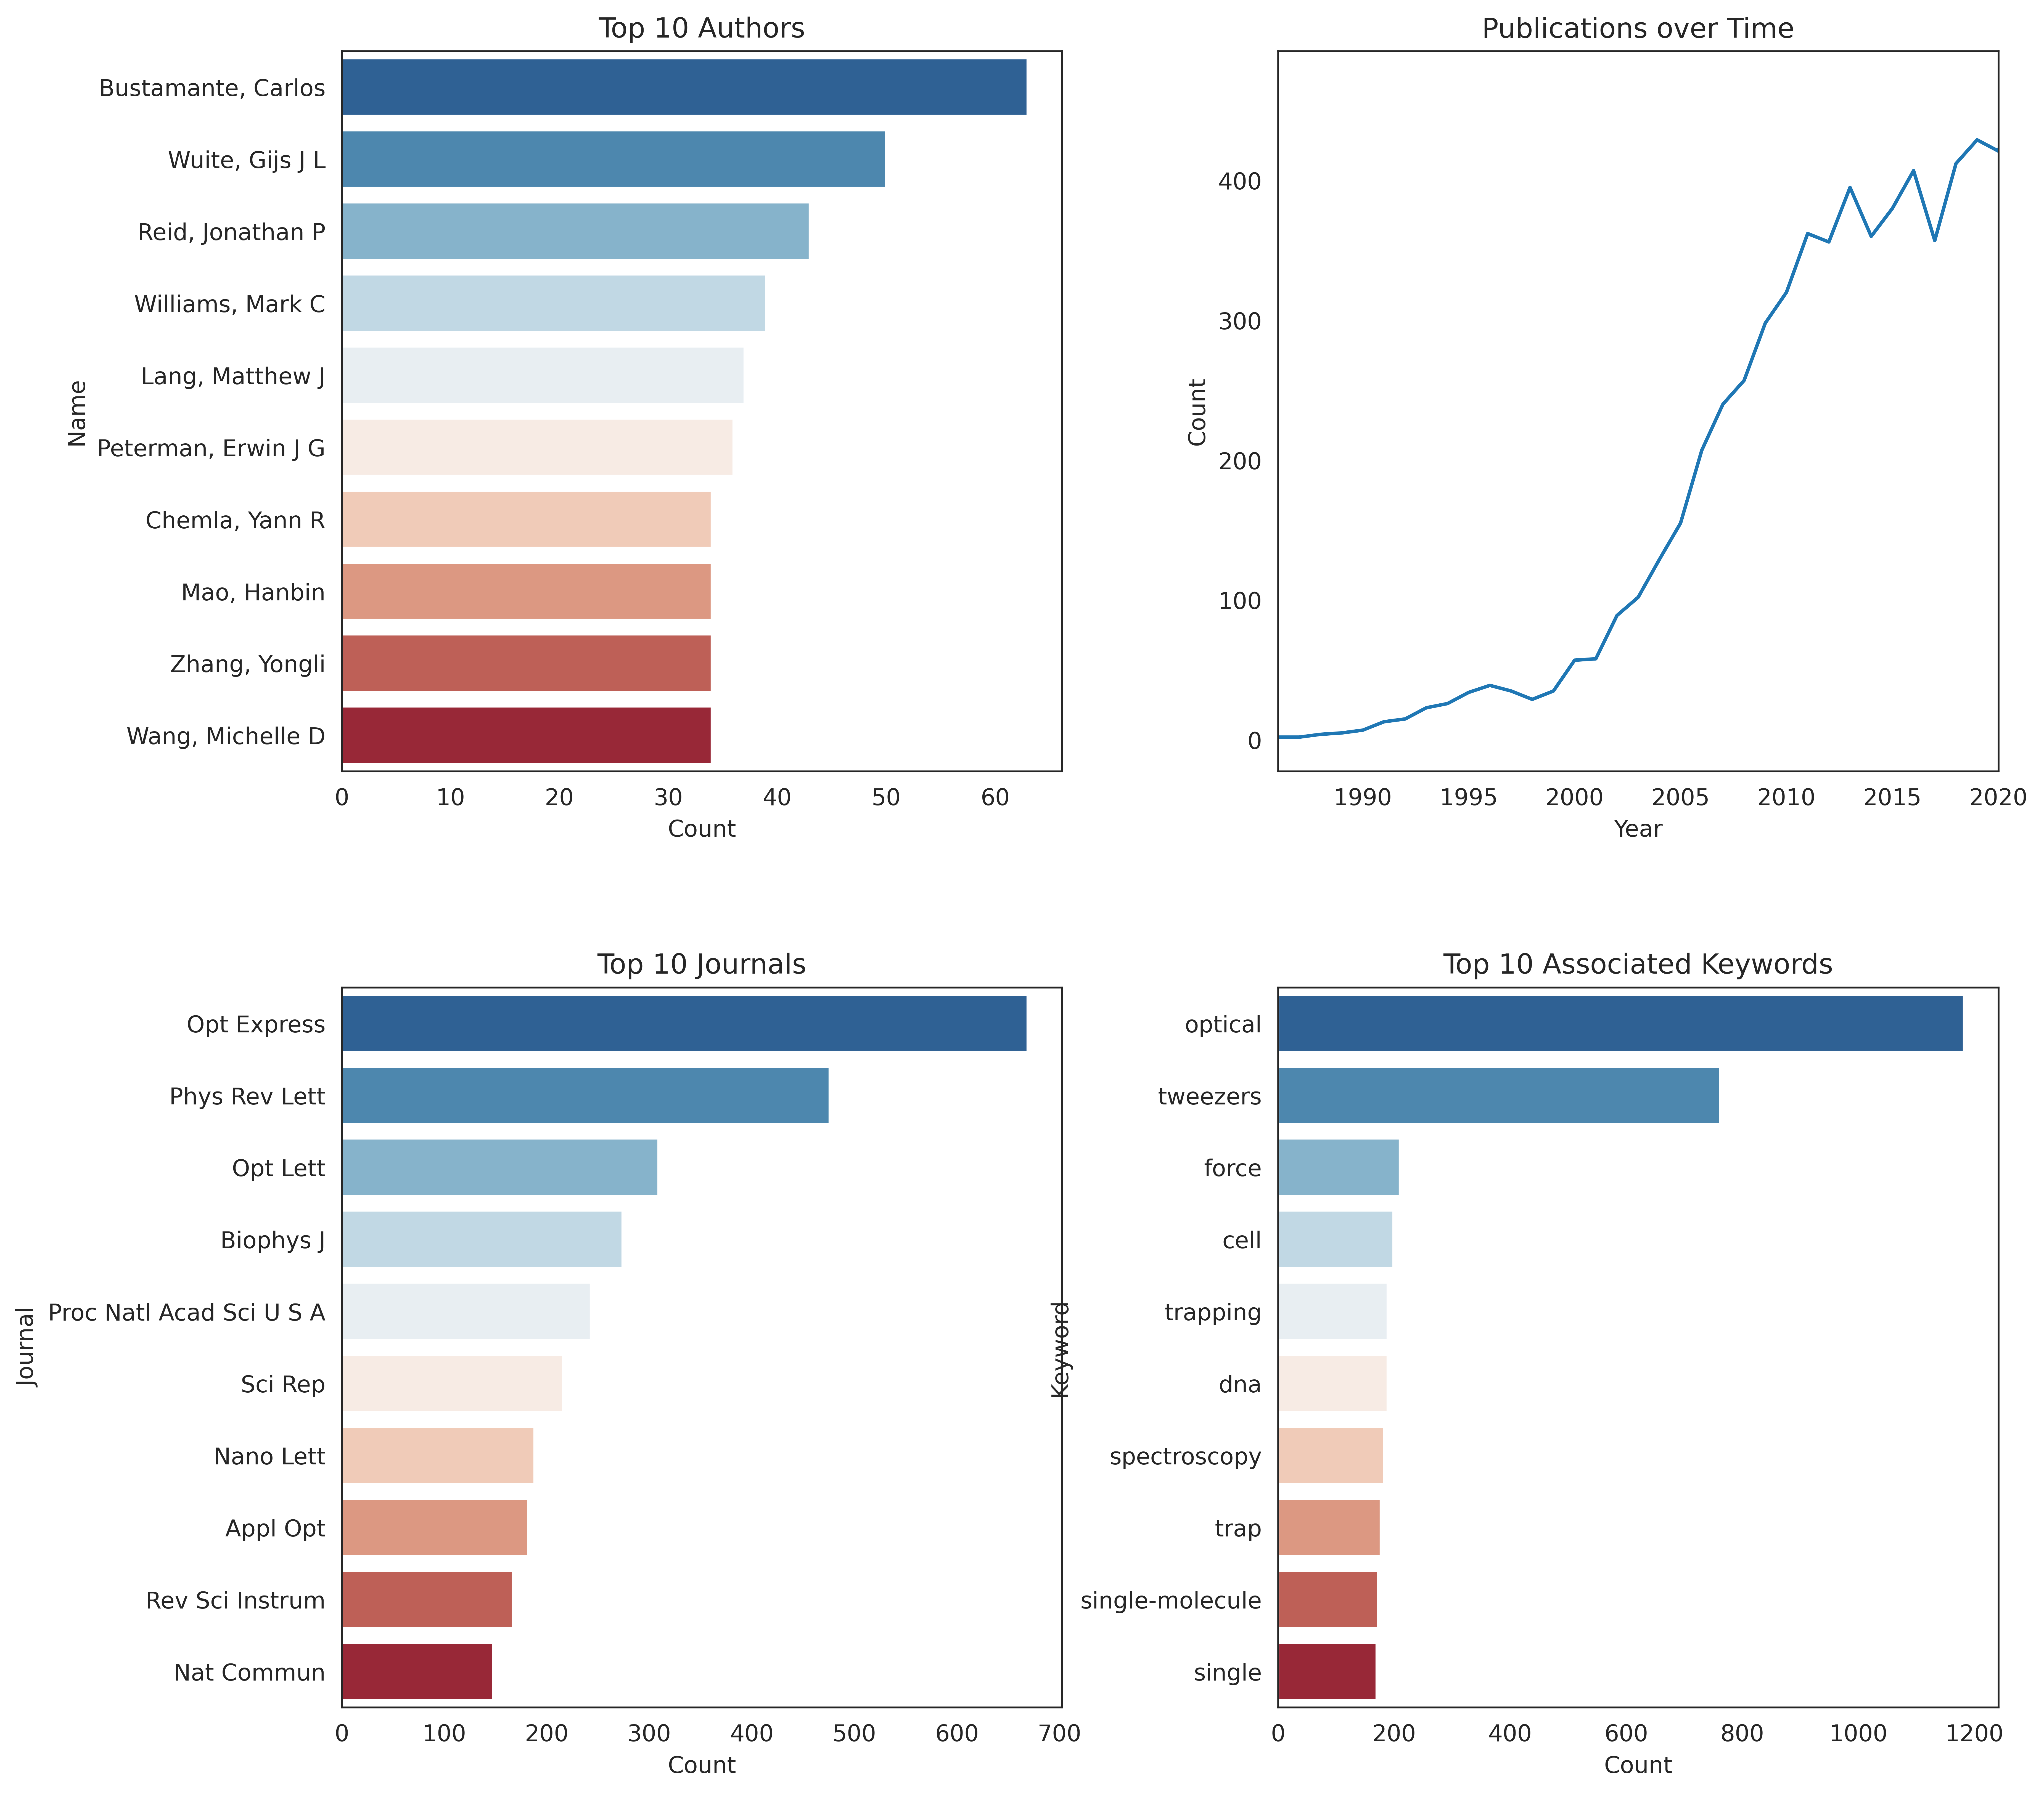

In [6]:
sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(10, 10), dpi=600)

# Top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")
plt.xlim([1986, 2020])


plt.subplot(2, 2, 3)

# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["TA"]).most_common(10),
    columns=["Journal", "Count"],
)

sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [
    _.lower()
    for kws in list(publication_data["OT"].dropna())
    for kw in kws
    for _ in kw.split(" ")
]

top10kw = pd.DataFrame.from_records(
    Counter(flat_kw).most_common(10), columns=["Keyword", "Count"]
)

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

In [7]:
from itertools import combinations

In [8]:
!pip install networkx

In [9]:
import networkx as nx

In [10]:
!pip install nxviz

In [11]:
from nxviz import CircosPlot

/usr/local/lib/python3.10/dist-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [12]:
# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))




In [13]:
G_50 = G.subgraph(top50_nodes)

In [14]:
for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


In [15]:
G_50

In [16]:
# NEW nxviz API

# check latest changes:
# https://github.com/ericmjl/nxviz
#
# Assume you have a graph G that is a NetworkX graph object.
# all nodes possess the "group" and "value" node attributes:
# "group" is categorical
# "value" is continuous,
# all edges have the "edge_value" attribute

import nxviz as nv


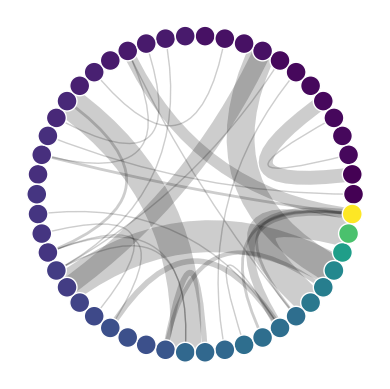

In [17]:
ax = nv.circos(
    G_50,
    group_by = "publications",
    node_color_by="publications",
    edge_lw_by = "Count"
)

# unfortunately no labels fix yet

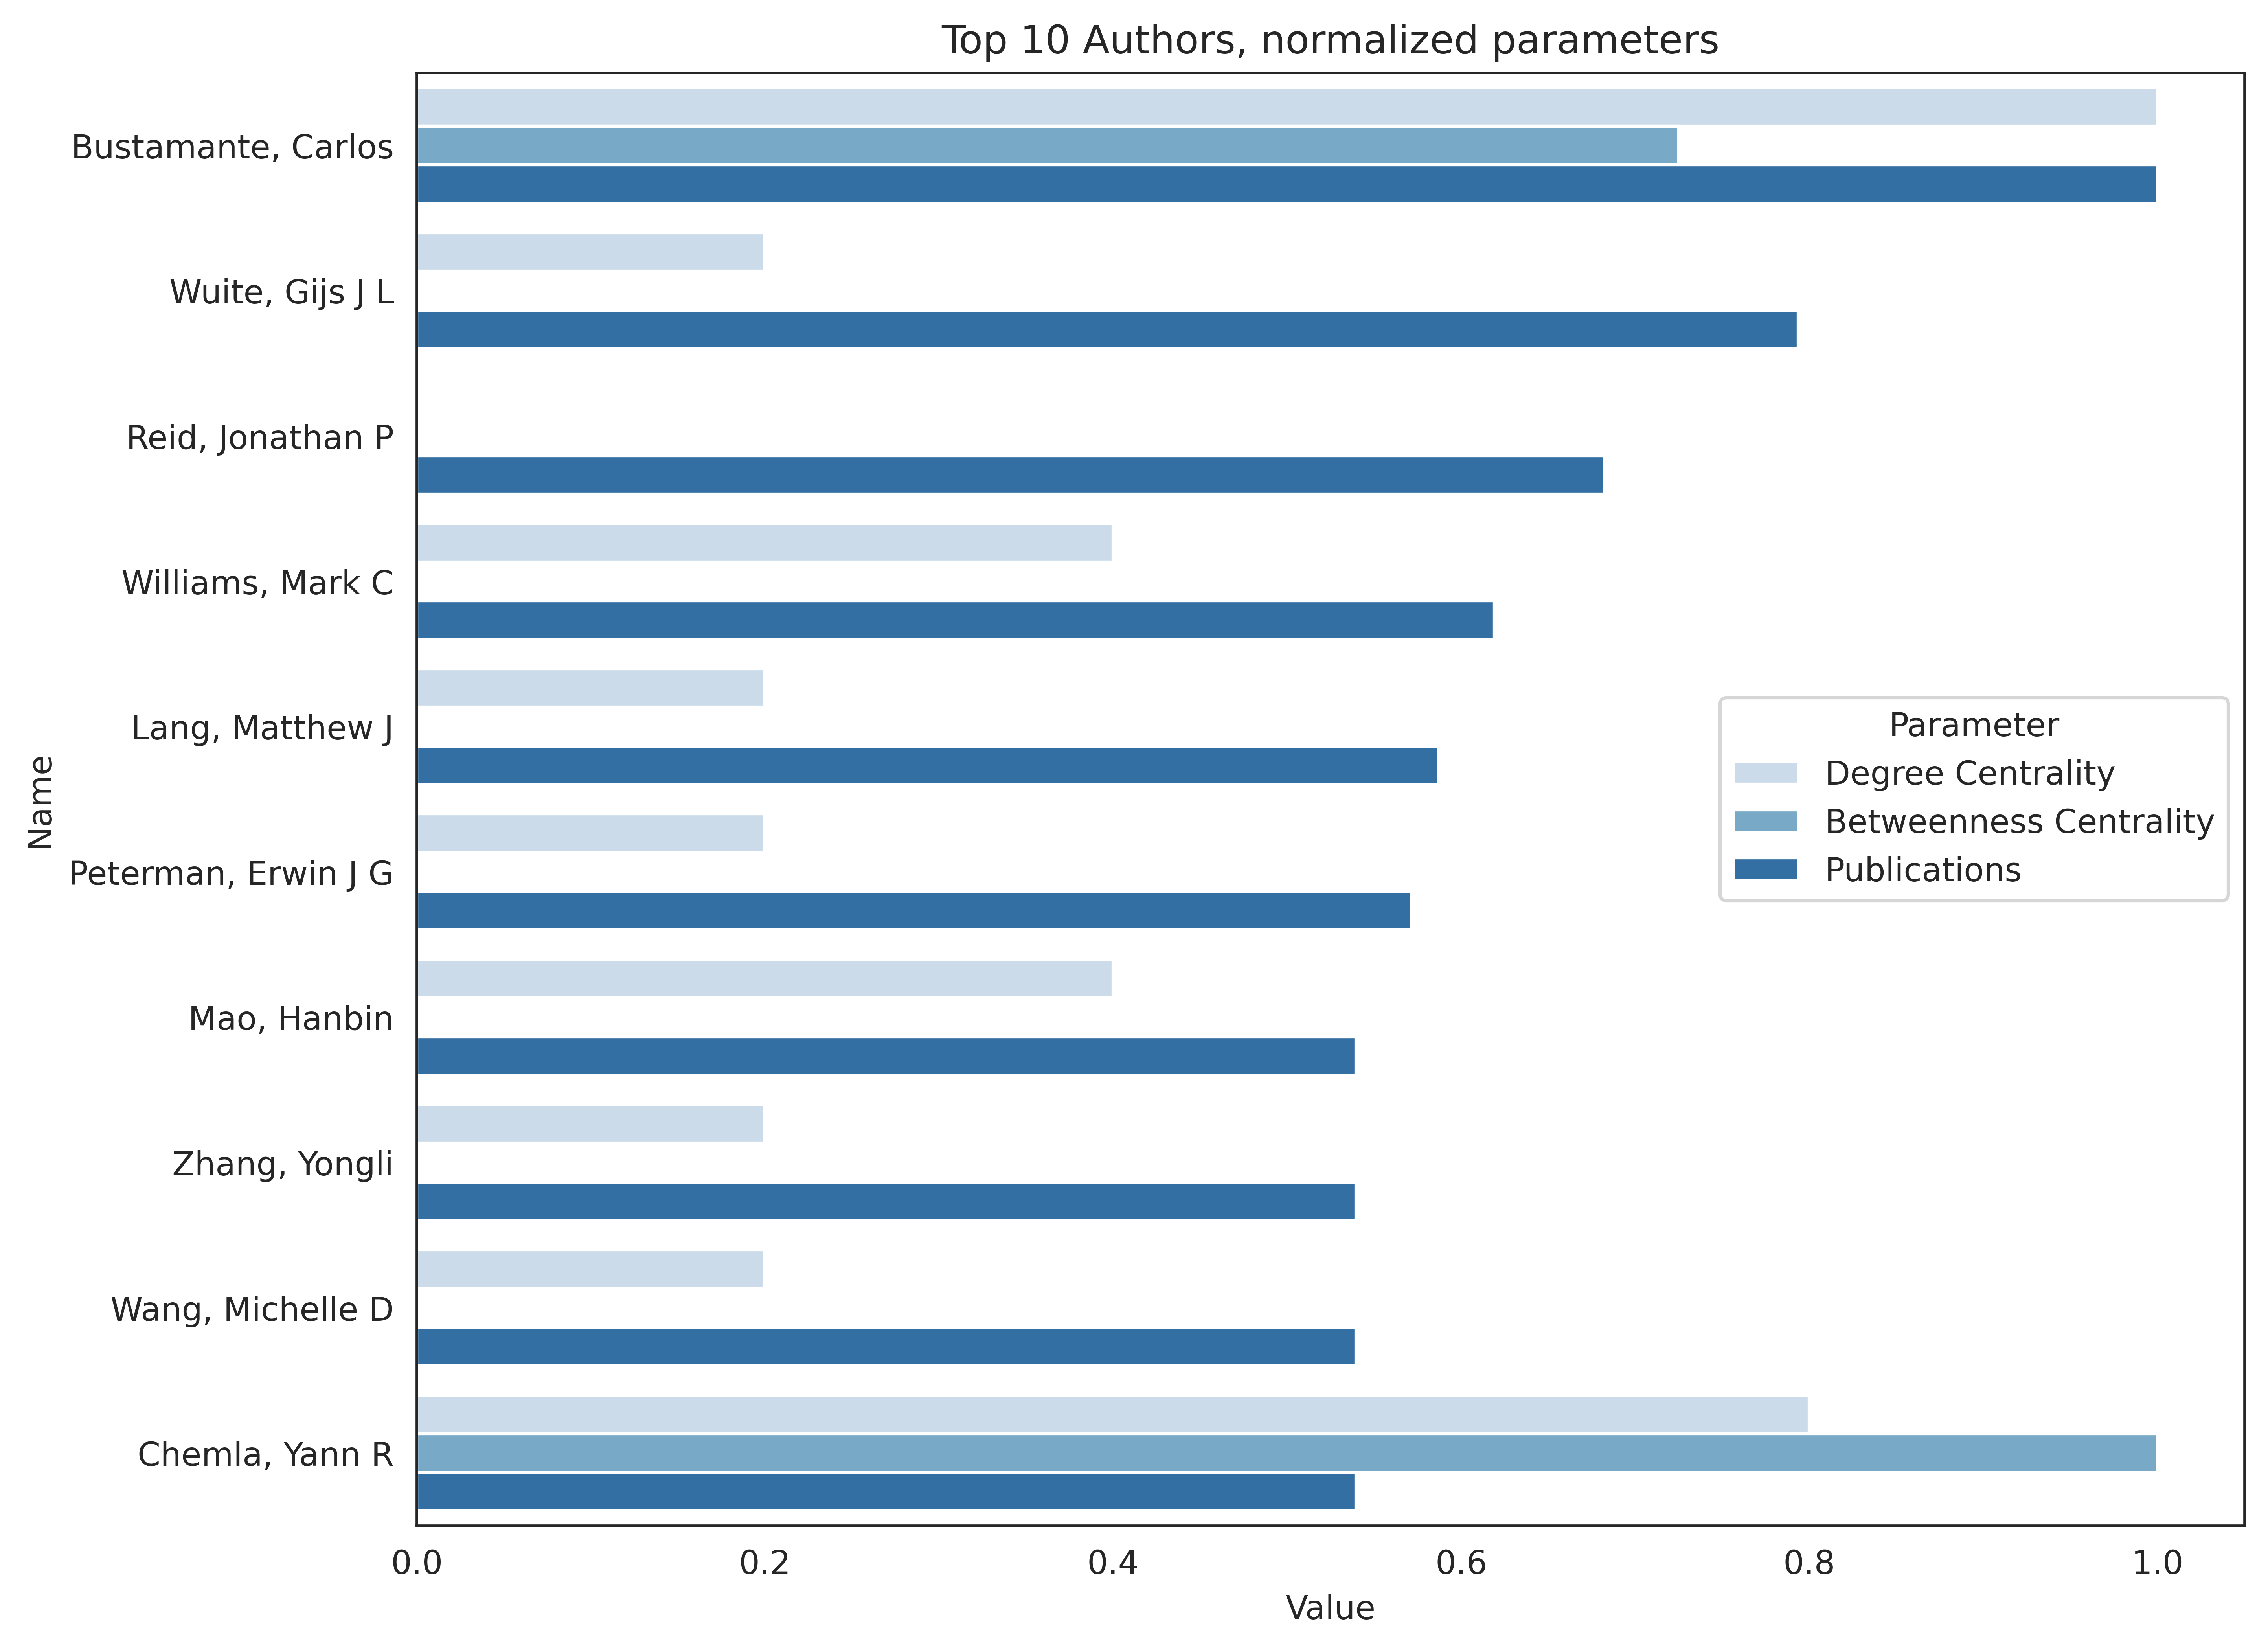

In [18]:
# how about centrality?
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()

In [19]:
# finding paths
# get in touch with a person of interest
paths = list(
    nx.all_shortest_paths(G, source="Ha, Taekjip", target="Bustamante, Carlos")
)

for path in paths:
    print(path)

['Ha, Taekjip', 'Chemla, Yann R', 'Bustamante, Carlos']
['Ha, Taekjip', 'Yu, Jin', 'Bustamante, Carlos']
